**AA228/CS238 Midterm3 2018 - Philippe Weingertner **
  
pweinger@stanford.edu

In [1]:
using ImageMagick
using Images
using Plots

In [2]:
using LaTeXStrings

* 4 States: $\theta \in \{20, 40, 60, 80\}$
* 10 Actions: $d \in \{10,20,...,100\}$ 
* 2 Observations: $c^1, c^0$

In [3]:
states  = [20, 40, 60, 80]
actions = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
observations = [:c0, :c1];

In [4]:
belief_uniform = [1/4, 1/4, 1/4, 1/4]
belief_θ20 = [1.0, 0, 0, 0]
belief_θ80 = [0,   0, 0, 1.0];

# Question 1

In [5]:
"""
    proba_obs_c1(θ::Int64, d::Int64)

OBSERVATION MODEL: return P(c1|s,a). With c1=catch successful, s=θ, a=d
"""
function proba_obs_c1(θ::Int64, d::Int64)
    p = 1-1/(1+exp(-(d-θ)/15))
end;

In [6]:
thetas = [20, 40, 60, 80]
colors = [:red, :green, :blue, :black]

plt = scatter([0], [0], color=:black, markersize=0.5, xlim=(0,100), 
                ylim=(0,1), xlabel="d", ylabel="\$ P(c^1  \\mid d) \$", 
                label="Question 1")

for i in 1:length(thetas)
    θ = thetas[i]
    d_vals = Float64[]
    p_vals = Float64[] 
    for d in 0:100
        p = proba_obs_c1(θ, d)
        push!(d_vals, d)
        push!(p_vals, p)
    end
    
    scatter!(plt, [d_vals], [p_vals], marker=:circle, color=colors[i], 
            markersize=2,xlim=(0,100),ylim=(0,1),label="\$\\theta=$θ\$")
end

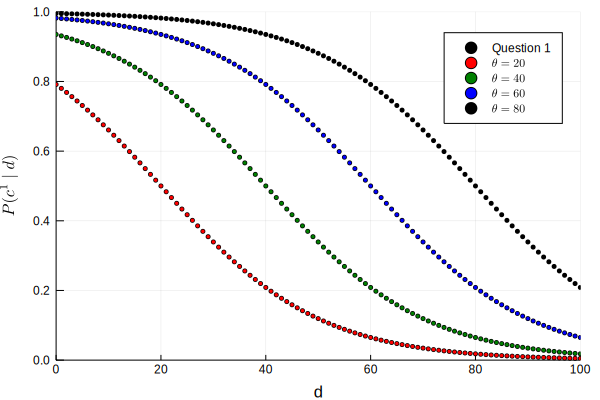

In [7]:
plt

$$ \boxed{\text{Plot }P(c1 \mid d) \text{ with c1=catch successful, }s=\theta,a=d} $$

# Question 2

In [8]:
const VecBelief = Array{Float64, 1}
const VecStates = Array{Int64, 1}
const VecActions = Array{Int64, 1}
const VecObservations = Array{Symbol, 1};

In [9]:
"""
    Reward_sa(s::Int64, a::Int64)

REWARD MODEL: return R(s,a). With s=θ, a=d
"""
function Reward_sa(s::Int64, a::Int64)
    r = a * proba_obs_c1(s, a)
    #println("R(s=$s, a=$a)=$r")
    return r
end;

In [10]:
"""
    Reward_ba(belief::VecBelief, a::Int64, states::VecStates)

REWARD MODEL: return R(b,a) Expected reward when executing 
                action a from belief b
"""
function Reward_ba(belief::VecBelief, a::Int64, states::VecStates)
    r = 0
    for i in 1:length(states)
        r += (Reward_sa(states[i], a) * belief[i])
    end
    #println("R(b=$belief, a=$a)=$r")
    return r
end;

In [11]:
"""
    Utility_1step_horizon_ba(belief::VecBelief, a::Int64, 
                                states::VecStates)

REWARD MODEL: return Expected Utility from executing action a 
                assuming a 1-step horizon
"""
function Utility_1step_horizon_ba(b::VecBelief, a::Int64, 
                                    states::VecStates)
    # With a 1-step horizon it is just the immediate reward
    return Reward_ba(b, a, states)
end;

In [12]:
function get_best_action_1step_horizon(belief::VecBelief, 
                            states::VecStates, actions::VecActions)
    best_action = -1
    best_utility = -Inf
    plt = scatter([0],[0],color=:black,markersize=0.5,xlim=(0,100), 
    ylim=(0,30),xlabel="a",ylabel="Utility_1steph(b,a) with b=$belief")

    for a in actions
        #println("a=$a")
        u = Utility_1step_horizon_ba(belief, a, states)
        if (u > best_utility)
            best_action = a
            best_utility = u
        end
        scatter!(plt, [a], [u], color=:blue, markersize=5, xlim=(0,100), 
                    ylim=(0,30), legend=false)
        #println(u)
    end

    println("Best action = $best_action with utility = $best_utility")
    return best_action, plt
end;

In [13]:
println("b=$belief_uniform")
println("states=$states")
println("actions=$actions")

best_action, plt = get_best_action_1step_horizon(belief_uniform, 
                                                states, actions)
println("1-step horizon best action = $best_action")

b=[0.25, 0.25, 0.25, 0.25]
states=[20, 40, 60, 80]
actions=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Best action = 50 with utility = 25.0
1-step horizon best action = 50


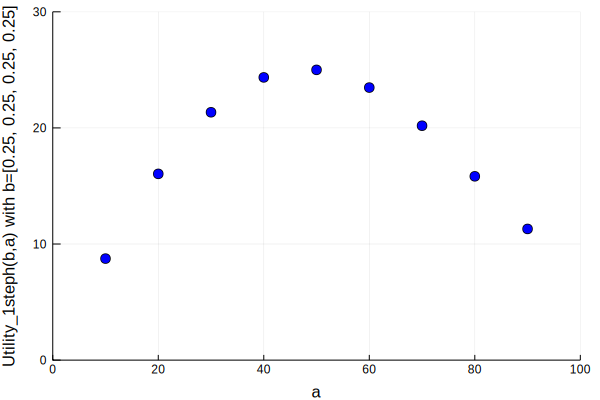

In [14]:
plt

$$ \boxed{\text{The best action with a uniform belief for 1-step horizon is action}=50}$$

# Question 3

In [15]:
println("belief=$belief_θ20")
best_action, plt = get_best_action_1step_horizon(belief_θ20, states, 
                                                    actions)
println("best_action = $best_action")

belief=[1.0, 0.0, 0.0, 0.0]
Best action = 30 with utility = 10.177308937025483
best_action = 30


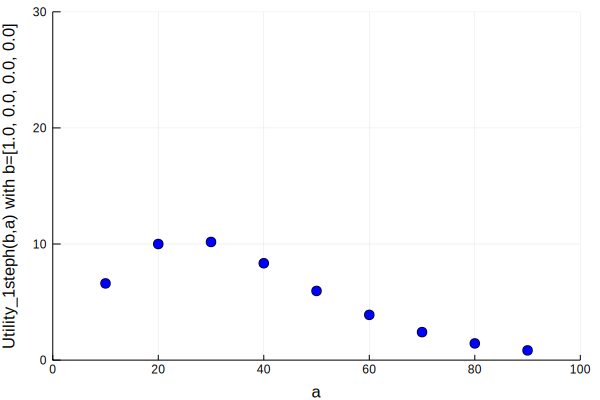

In [16]:
plt

$$ \boxed{\text{The best action with belief } \theta=20\text{ certain for 1-step horizon is action}=30}$$

# Question 4

  
**Transition Model:**
$$T(s' \mid s,a) = 1 \text{ if } s'=s$$
$$T(s' \mid s,a) = 0 \text{ if } s'\neq s$$  
  
Because $\theta$ remains (unobservable directly) but constant over steps: hidden but constant  
  
  
**Belief Update:** Cf DMU 6.2.1: Belief Updating with Discrete State Filter  
$$b'(s')=P(s' \mid o,a,b)$$  
$$b'(s') \propto O(o \mid s',a) \sum_s T(s' \mid s,a) \: b(s)$$  

And based on our "Playing Catch" Transition Model:  
$$b'(s') \propto O(o \mid s',a) \: b(s')$$

In [17]:
"""
    proba_obs(o::Symbol, s::Int64, a::Int64)

OBSERVATION MODEL: return P(o|s,a). With o being :c0 or :c1, s=θ, a=d
"""
function proba_obs(o::Symbol, s::Int64, a::Int64)
    if o == :c1
        return proba_obs_c1(s, a)
    else
        return 1 - proba_obs_c1(s, a)
    end
end;

In [18]:
"""
    UpdateBelief(b::VecBelief, a::Int64, o::Symbol, 
                    states::VecStates)

FILTER UpdateBelief: return new belief based on current belief, 
                        action and observation
"""
function UpdateBelief(b::VecBelief, a::Int64, o::Symbol, 
                        states::VecStates)
    bp = copy(b)
    for i in 1:length(b)
        bp[i] = proba_obs(o, states[i], a) * b[i]
    end
    bp = bp / sum(bp)
    return bp
end;

In [19]:
b = [1/4, 1/4, 1/4, 1/4] # uniform prior belief
a = 30 # action: catch at distance of 30 meters
o = :c1 # we observe a successful catch

bp = UpdateBelief(b, a, o, states)

4-element Array{Float64,1}:
 0.11918541531789291
 0.23214149061189945
 0.3094477121579715 
 0.3392253819122361 

$$ \boxed{
[0.12, 0.23, 0.31, 0.34]=UpdateBelief(b=\text{uniform}, a=30, o=:c1)}$$

# Question 5

In [20]:
b = [1/4, 1/4, 1/4, 1/4] # prior uniform belief
a = 100 # action: catch at distance of 100 meters
o = :c1 # we observe a successful catch

for i in 1:4
    b = UpdateBelief(b, a, o, states)
    println(b)
end

[0.0162121, 0.0606886, 0.219217, 0.703882]
[0.0004801, 0.00672773, 0.0877817, 0.90501]
[1.18527e-5, 0.00062176, 0.0293039, 0.970062]
[2.78782e-7, 5.47444e-5, 0.00931988, 0.990625]


 Which makes sense: the most probable state is $\theta=80$  
 If we can catch successfuly, 4 times in a row, starting from a uniform prior, at 100 meters

$$ \boxed{\text{Our new belief is }\approx [0.00, \: 0.00, \: 0.01, \: 0.99]}$$

# Question 6

Cf DMU section 6.3.2 & 6.3.3   
And figure 6.4 for an example 3-step conditional plan

We have: h = 4, |O| = 2, |A| = 10  
  
$$\boxed{n\_nodes=\frac{|O|^h-1}{|O|-1}=\frac{2^4-1}{2-1}=15}$$

The number of possible h-step plans is:  
$$\boxed{n\_plans= |A|^{n\_nodes}=10^{15}}$$

# Question 7

We can recursively compute $U^P(s)$, the expected utility associated with conditional plan $P$ when starting in state s with:  
  
$$ U^P(s)=R(s,a) + \sum_{s'} T(s' \mid s,a) \sum_o O(o \mid s',a) \: U^{P(o)}(s')$$  
  
Where $a$ is the action associated with the root node of $P$ and $P(o)$ represents the subplan associated with observation $o$  
  
With our Transition model:   
$$T(s' \mid s,a) = 1 \text{ if } s'=s$$
$$T(s' \mid s,a) = 0 \text{ if } s'\neq s$$  
  
So we have:  
  
$$ U^P(s)=R(s,a) +  \sum_o O(o \mid s,a) \: U^{P(o)}(s)$$   

In [25]:
function Utility_Pjohnny(s::Int64, a::Int64, h::Int64)
    if h == 0
        return 0
    end
    
    u = Reward_sa(s, a)
    u += proba_obs(:c0, s, a) * Utility_Pjohnny(s, a-10, h-1)
    u += proba_obs(:c1, s, a) * Utility_Pjohnny(s, a+10, h-1)
    #println("Pjohnny: s=$s a=$a h=$h u=$u")
    return u
end;

In [26]:
function compute_α_johnny(root_a::Int64, h::Int64, 
                            states::VecStates)
    
    α = zeros(Float64, length(states))
    for i in 1:length(states)
        α[i] = Utility_Pjohnny(states[i], root_a, h)
    end
    return α
end;

In [27]:
root_a = 50
h = 4

α_johnny = compute_α_johnny(root_a, h, states)

4-element Array{Float64,1}:
  31.562110114119033
  69.14152457714357 
 121.95210828903213 
 179.38638822051192 

$$ \boxed{\text{The alpha vector for Johnny's policy is: } \alpha_{Johnny}=[31.56, \: 69.14, \: 121.95, \: 179.39]}$$

# Question 8

The expected utility associated with a belief state can be computed as:  
$U^P(b)=\sum_s U^P(s) \: b(s)$  
$U^P(\mathbf{b})= \mathbf{\alpha_P}^T \: \mathbf{b}$ which is a dot product between $\alpha$ vector and belief vector

In [28]:
using LinearAlgebra

const VecAlpha = Array{Float64, 1};

In [29]:
"""
    Utility_bα(b::VecBelief, α::VecAlpha)

UTILITY: returns expected utility based on a belief 
            and an alpha-vector 
"""
function Utility_bα(b::VecBelief, α::VecAlpha)
    return transpose(α) * b
end;

In [30]:
println(belief_θ80)
println(α_johnny)
Utility_bα(belief_θ80, α_johnny)

[0.0, 0.0, 0.0, 1.0]
[31.5621, 69.1415, 121.952, 179.386]


179.38638822051192

$$ \boxed{\text{The 4-steps strategy from Johnny has an expeted utility } U^{Johnny}(\text{belief}\:\theta80)=179.39}$$

In [31]:
println(belief_uniform)
println(α_johnny)
Utility_bα(belief_uniform, α_johnny)

[0.25, 0.25, 0.25, 0.25]
[31.5621, 69.1415, 121.952, 179.386]


100.51053280020167

$$ \boxed{\text{The 4-steps strategy from Johnny has an expeted utility } U^{Johnny}(\text{belief Uniform})=100.51}$$

# Question 9

**1-step lookahead policy:**  

$$ \pi(b) = argmax_a \: [R(b,a) + \gamma \sum_o P(o \mid b,a) \: U(\text{UpdateBelief}(b,a,o))]$$  

As a reminder, by applying the Law of Total Probability multiple times we have:  
  
$$ P(o \mid a,b) = \sum_s P(o, s \mid a,b) = \sum_s P(o  \mid a,b,s) \: p(s \mid a,b)$$
$$ P(o \mid a,b) = \sum_s b(s) \: P(o  \mid a,b,s) = \sum_s b(s) \: P(o  \mid a,s)$$
$$ P(o \mid a,b) = \sum_s b(s) \: P(o  \mid a,s) = \sum_s b(s) \: \sum_{s'} P(o, s'  \mid a,s) $$
$$ P(o \mid a,b) = \sum_s b(s) \: \sum_{s'} P(o \mid a,s,s') \: P(s' \mid a,s) $$
$$ P(o \mid a,b) = \sum_s b(s) \: \sum_{s'} P(o \mid a,s') \: P(s' \mid a,s) $$
  
$$ P(o \mid b,a) = \sum_s b(s) \sum_{s'} O(o \mid s',a) \: T(s' \mid s,a)$$  
  
With our Transition model:   
$$T(s' \mid s,a) = 1 \text{ if } s'=s$$
$$T(s' \mid s,a) = 0 \text{ if } s'\neq s$$  
  
$\gamma=1$ as we are dealing with finite horizon  
  
So we have:  
$$ P(o \mid b,a) = \sum_s b(s) \: O(o \mid s,a)$$  

In [36]:
"""
    proba_obs(o::Symbol, belief::VecBelief, a::Int64, 
                states::VecStates)

OBSERVATION MODEL: return P(o|b,a). With o being :c0 or :c1, 
                        b=belief, a=d
"""
function proba_obs(o::Symbol, belief::VecBelief, a::Int64, 
                    states::VecStates)
    p = 0
    for i in 1:length(states)
        p += belief[i] * proba_obs(o, states[i], a)
    end
    return p
end;

In [37]:
?proba_obs

search: proba_obs proba_obs_c1



```
proba_obs(o::Symbol, s::Int64, a::Int64)
```

OBSERVATION MODEL: return P(o|s,a). With o being :c0 or :c1, s=θ, a=d

---

```
proba_obs(o::Symbol, belief::VecBelief, a::Int64, 
            states::VecStates)
```

OBSERVATION MODEL: return P(o|b,a). With o being :c0 or :c1,                          b=belief, a=d


**1-step lookahead policy:**  

$$ \pi(b) = argmax_a \: [R(b,a) + \gamma \sum_o P(o \mid b,a) \: U(\text{UpdateBelief}(b,a,o))]$$  

In [38]:
function Lookahead_1step(b::VecBelief, α::VecAlpha, states::VecStates, 
                    actions::VecActions, observations::VecObservations)
    
    best_action = nothing
    best_utility = -Inf
    
    for a in actions
        utility = Reward_ba(b ,a, states)
        for o in observations
            p = proba_obs(o, b, a, states)
            bp = UpdateBelief(b, a, o, states)
            utility += p * Utility_bα(bp, α)
        end
        
        println("utility($a)=$utility")
        
        if utility > best_utility
            best_utility = utility
            best_action = a
        end
    end
    
    return best_action
end;

In [39]:
belief = [0.5, 0.5, 0, 0]
println(α_johnny)
println(states)
println(actions)
println(observations)

Lookahead_1step(belief, α_johnny, states, actions, observations)

[31.5621, 69.1415, 121.952, 179.386]
[20, 40, 60, 80]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Symbol[:c0, :c1]
utility(10)=58.0595845793498
utility(20)=63.26573207237086
utility(30)=65.3518173456313
utility(40)=64.5239878921522
utility(50)=61.81298117703882
utility(60)=58.55914823927257
utility(70)=55.72950146472281
utility(80)=53.670032509261524
utility(90)=52.3210693211388
utility(100)=51.491365488093855


30

$$ \boxed{\text{The 1-step lookahead with } \alpha_{Johnny} \text{ and a belief } b=[0.5, 0.5, 0 ,0] \text{ leads to action } a=30 }$$

# Question 10

I will use a Forward Search algorithm extending the one-step lookahead strategy to a depth corresponding to our finite horizon. To compute the value for an action a, we evaluate:
  
$$ \boxed{R(b,a) + \gamma \sum_o P(o \mid b,a) \: U_{d-1}(\text{UpdateBelief}(b,a,o))}$$
  
As a reminder, by applying the Law of Total Probability multiple times we have:  
  
$$ P(o \mid a,b) = \sum_s P(o, s \mid a,b) = \sum_s P(o  \mid a,b,s) \: p(s \mid a,b)$$
$$ P(o \mid a,b) = \sum_s b(s) \: P(o  \mid a,b,s) = \sum_s b(s) \: P(o  \mid a,s)$$
$$ P(o \mid a,b) = \sum_s b(s) \: P(o  \mid a,s) = \sum_s b(s) \: \sum_{s'} P(o, s'  \mid a,s) $$
$$ P(o \mid a,b) = \sum_s b(s) \: \sum_{s'} P(o \mid a,s,s') \: P(s' \mid a,s) $$
$$ P(o \mid a,b) = \sum_s b(s) \: \sum_{s'} P(o \mid a,s') \: P(s' \mid a,s) $$
  
With our Transition model:
$$P(s' \mid s,a) = 1 \text{ if } s'=s$$
$$P(s' \mid s,a) = 0 \text{ if } s'\neq s$$
So we end up with:
$$ \boxed{P(o \mid a,b) = \sum_s b(s) \:  P(o \mid a,s)} $$

In [40]:
# Forward Search algorithm used over h-step horizon

"""
    SelectAction(b::VecBelief, h::Int64, 
                    states::VecStates, actions::VecActions, 
                    observations::VecObservations)

FORWARD SEARCH: return (best_action, best_utility) 
        for a finite h-step horizon problem based on current belief
"""
function SelectAction(b::VecBelief, h::Int64, states::VecStates, 
                    actions::VecActions, observations::VecObservations)
    
    if h == 0
        return -1, 0 # for inf horizon we would use a U(b) approximation
    end
    
    best_a = -1
    best_u = -Inf
    
    for a in actions
        u = Reward_ba(b, a, states)
        for o in observations
            bp = UpdateBelief(b, a, o, states)
            ap, up = SelectAction(bp, h-1, states,actions,observations)
            u += proba_obs(o, b, a, states) * up
        end
        
        if u > best_u
            best_u = u
            best_a = a
        end
    end
    #println("h=$h best_a=$best_a best_u=$best_u")
    return (best_a, best_u)
    
end;

In [41]:
println(belief_uniform)
println(states, actions, observations)

# Just check with 1-step plan: we should get back Q2 answer
h = 1
SelectAction(belief_uniform, h, states, actions, observations)

[0.25, 0.25, 0.25, 0.25]
[20, 40, 60, 80][10, 20, 30, 40, 50, 60, 70, 80, 90, 100]Symbol[:c0, :c1]


(50, 25.0)

Sanity check ok: we find same result than in question 2 with a 1-step plan.

In [73]:
h = 4
println(belief_uniform)
println(states, actions, observations)
@time SelectAction(belief_uniform, h, states, actions, observations)

[0.25, 0.25, 0.25, 0.25]
[20, 40, 60, 80][10, 20, 30, 40, 50, 60, 70, 80, 90, 100]Symbol[:c0, :c1]
  0.067787 seconds (362.11 k allocations: 36.493 MiB, 11.40% gc time)


(50, 103.28237451968727)

This utility is better than the one from Johnny. So it looks consistent.

$$ \boxed{\text{The optimal 4-steps strategy has root action } a=50 \text{ and an expeted utility } U^*(\text{belief Uniform})=103.28}$$

# Question 11

I did this question in 2 different ways. My first implementation corresponding to Question 11.b below, was actually doing several h-step searches: to retrieve the best action from every one of the 15 policy tree nodes. But this is not efficient: after a single h-step search from h=4 we should already have all the relevant information.  
  
So I did a new version in question 11.a below: the Forward Search procedure from **Question 10** is modified such that it keeps tracks of the SearchTree. And then we just have to extract from this SearchTree the policy tree in a format suitable for D3Trees dump.  
  
We can check that the results obtained by the 2 different methods are the same but that method 11.a is faster.  

## Question 11.a: more efficient way

In [48]:
using Parameters # for @with_kw

In [122]:
@with_kw mutable struct ActionNodeInfo
    belief::VecBelief = belief_uniform
    id::Int64 = -1
    parent::Int64 = -1
    
    # best_c0child best_c1child
    best_obschild::Vector{Int64} = []
    best_u::Float64 = -Inf
    best_a::Int64 = -1
end;

In [123]:
function ActionNodeInfo(n_obs::Int64)
    node = ActionNodeInfo()
    node.best_obschild = [-1 for i in 1:n_obs]
    return node
end;

In [124]:
# Forward Search algorithm used over h-step horizon 
# + keeps track of SearchTree

"""
    TreeSelectAction(b::VecBelief, h::Int64, parentid::Int64,
                    states::VecStates, actions::VecActions, 
                    observations::VecObservations)

FORWARD SEARCH: return (best_action, best_utility) 
        for a finite h-step horizon problem based on current belief
        and keeps track of the SearchTree
"""
function TreeSelectAction(b::VecBelief, h::Int64,  parentid::Int64,
                        states::VecStates, actions::VecActions, 
                        observations::VecObservations)
        
    if h == 0
        return nothing, 0, -1
    end
    
    best_a = nothing
    best_u = -Inf
    
    nid = length(SearchTree) + 1 # XXXX
    
    node = ActionNodeInfo(length(observations))
    push!(SearchTree, node)
    node.id = length(SearchTree)
    
    node.belief = b
    node.parent = parentid
    
    obschild = [-1 for i in 1:length(observations)]
        
    for a in actions
        u = Reward_ba(b, a, states)
        
        for (i, o) in enumerate(observations)
            bp = UpdateBelief(b, a, o, states)
            ap, up, cid  = TreeSelectAction(bp, h-1, nid, 
                                states,actions,observations)
            u += proba_obs(o, b, a, states) * up
            if cid > 0
                obschild[i] = cid
            end
        end
        
        if u > best_u
            best_u = u
            best_a = a
            
            node.best_u = u
            node.best_a = a
            for i in 1:length(observations)
                node.best_obschild[i] = obschild[i]
            end
        end
        
    end
    
    return best_a, best_u, nid
end;

In [136]:
h = 4

 # this is the only var used as global ...
global SearchTree = ActionNodeInfo[]

println(belief_uniform)
println(states, actions, observations)

# We redo question 10 ...
# But this time we call TreeSelectAction instead of SelectAction
# which will update and keep track of the SearchTree
@time TreeSelectAction(belief_uniform, h, -1, states,actions,observations)

[0.25, 0.25, 0.25, 0.25]
[20, 40, 60, 80][10, 20, 30, 40, 50, 60, 70, 80, 90, 100]Symbol[:c0, :c1]
  0.086977 seconds (529.86 k allocations: 42.001 MiB, 14.55% gc time)


(50, 103.28237451968727, 1)

In [137]:
using D3Trees

In [138]:
function GetPolicyTree(h::Int64, SeachTreeId::Int64, 
            Pchildren::Vector{Vector{Int64}}, 
            Ptext::Vector{String}, observations::VecObservations)

    if h == 0
        return -1
    end
        
    push!(Ptext, string("action\n", SearchTree[SeachTreeId].best_a))
    push!(Pchildren, [])
    shortid = length(Ptext) 
        
    for i in 1:length(observations)
        short_cid = GetPolicyTree(h-1, 
                        SearchTree[SeachTreeId].best_obschild[i], 
                        Pchildren, Ptext, observations)
        if short_cid > 0
            push!(Pchildren[shortid], short_cid)
        end
    end
    
    return shortid
end;

In [143]:
h = 4
Pchildren = Vector{Int64}[]
Ptext = String[];
@time GetPolicyTree(h, 1, Pchildren, Ptext, observations);

  0.000041 seconds (208 allocations: 8.922 KiB)


In [144]:
println(Pchildren)
println(Ptext)

Array{Int64,1}[[2, 9], [3, 6], [4, 5], [], [], [7, 8], [], [], [10, 13], [11, 12], [], [], [14, 15], [], []]
["action\n50", "action\n40", "action\n30", "action\n30", "action\n30", "action\n40", "action\n40", "action\n50", "action\n50", "action\n50", "action\n40", "action\n50", "action\n60", "action\n50", "action\n60"]


We can check that the call to **GetPolicyTree()** is much faster than the call to **SelectAction()**

In [145]:
# And now we can get a nice interactive display with D3Tree
# NB: to use D3Tree you need an online connection
Panna = D3Tree(Pchildren, text=Ptext, init_expand=h);

To enable the ipynb to pdf generation, I have to save the Panna image generated by D3Tree and load it.  
Otherwise I get a failure message (nbconvert failed...)

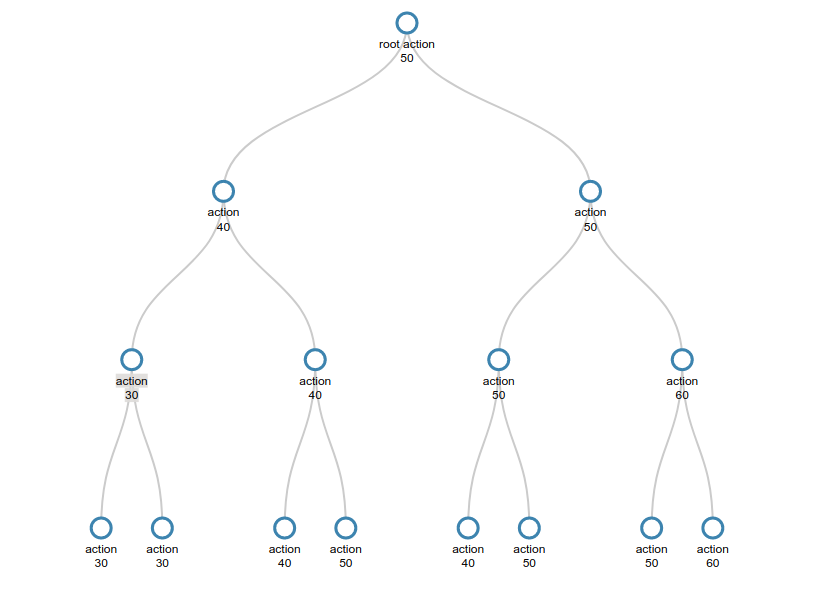

In [146]:
img = load("Panna.png")

We can see that the optimal policy proposed by Anna has many nodes in common with the policy proposed by Johnny. Which is consistent with the fact that the utilities are indeed pretty close. So Johnny had some good intuition about what to do.

## Question 11.b: less efficient way

In [80]:
using D3Trees

In [81]:
# convert a sequence of observations to a NodeId in a PolicyTree
"""
    GetNodeId(history_o::VecObservations)

POLICY TREE UTILITY: converts a history of observations 
                        to a unique NodeId
"""
function GetNodeId(history_o::VecObservations)
    id = 1
    mult = 1
    for o in history_o
        if o == :c0
            id += 1 * mult
        elseif o == :c1
            id += 2 * mult
        end
        mult *= 2
    end
    return id
end;

In [82]:
"""
    GetPolicyTree(b::VecBelief, a::Int64, h::Int64, 
                    history_o::VecObservations, tree::D3Tree, 
                    states::VecStates, actions::VecActions, 
                    observations::VecObservations)

POLICY TREE UTILITY: updates a D3Tree structure 
                        for a finite h-steps optimal 
                        policy starting with root action a and belief b
"""
function GetPolicyTree(b::VecBelief, a::Int64, h::Int64, 
                        history_o::VecObservations, tree::D3Tree, 
                        states::VecStates, actions::VecActions, 
                        observations::VecObservations)
    h -= 1
    for o in observations
        parent_id = GetNodeId(history_o)
        push!(history_o, o)
        node_id = GetNodeId(history_o)
        push!(tree.children[parent_id], node_id)
        
        bp = UpdateBelief(b, a, o, states)
        ap, up = SelectAction(bp, h, states, actions, observations)
        
        tree.text[node_id] = "action\n$ap"
        println("h=$h a=$ap history_o=$history_o")
        if h > 1
            GetPolicyTree(bp, ap, h, history_o, tree, 
                            states, actions, observations)
        end
        pop!(history_o)
    end

end;

In [83]:
println("belief_uniform=$belief_uniform")
println("sates=$states")
println("actions=$actions")
println("observations=$observations")

h = 4
b = belief_uniform
root_a = 50
history_o = Symbol[]

n_obs = length(observations)
n_nodes = Int64((n_obs^h - 1)/(n_obs - 1))
println(n_nodes)

empty_tree=[[] for i in 1:n_nodes]
Panna = D3Tree(empty_tree, init_expand=h)
Panna.text[1] = "root action\n$root_a" 
Panna.tooltip

println("We dump the policy tree in text")
println("and retieve it also in D3Tree format (Panna)")
@time GetPolicyTree(b, root_a, h, history_o, Panna, 
                states, actions, observations)

belief_uniform=[0.25, 0.25, 0.25, 0.25]
sates=[20, 40, 60, 80]
actions=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
observations=Symbol[:c0, :c1]
15
We dump the policy tree in text
and retieve it also in D3Tree format (Panna)
h=3 a=40 history_o=Symbol[:c0]
h=2 a=30 history_o=Symbol[:c0, :c0]
h=1 a=30 history_o=Symbol[:c0, :c0, :c0]
h=1 a=30 history_o=Symbol[:c0, :c0, :c1]
h=2 a=40 history_o=Symbol[:c0, :c1]
h=1 a=40 history_o=Symbol[:c0, :c1, :c0]
h=1 a=50 history_o=Symbol[:c0, :c1, :c1]
h=3 a=50 history_o=Symbol[:c1]
h=2 a=50 history_o=Symbol[:c1, :c0]
h=1 a=40 history_o=Symbol[:c1, :c0, :c0]
h=1 a=50 history_o=Symbol[:c1, :c0, :c1]
h=2 a=60 history_o=Symbol[:c1, :c1]
h=1 a=50 history_o=Symbol[:c1, :c1, :c0]
h=1 a=60 history_o=Symbol[:c1, :c1, :c1]
  0.079742 seconds (106.86 k allocations: 7.112 MiB, 9.56% gc time)


In [84]:
#Panna # you need an internet connection to dump it

In [85]:
#HTML("""<img src="Panna.png"/>""")

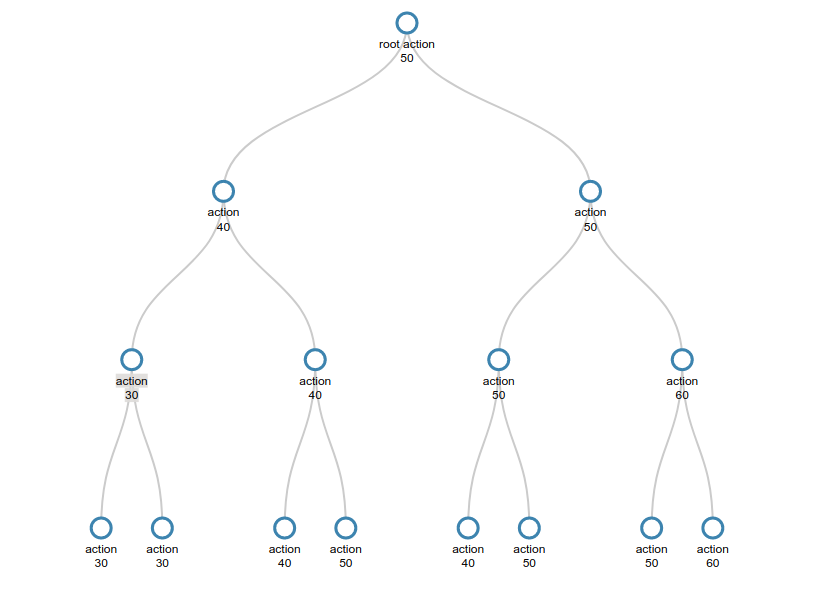

In [86]:
img = load("Panna.png")
#plot(img)

We can see that the optimal policy proposed by Anna has many nodes in common with the policy proposed by Johnny. Which is consistent with the fact that the utilities are indeed pretty close. So Johnny had some good intuition about what to do.